<a href="https://colab.research.google.com/github/thanujTa/machine-learning-projects/blob/main/Transfer_Learning_Part_3_Scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensoFlow part3: Scaling up(Food Vision Mini)

In [1]:
!nvidia-smi

Tue Apr 12 06:39:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
## creating helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-04-12 06:39:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-04-12 06:39:17 (47.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys , walk_through_dir

In [4]:
# get the data  of 101 classes

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

--2022-04-12 06:39:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 209.85.146.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   172MB/s    in 10s     

2022-04-12 06:39:31 (153 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [6]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_and_sour_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gyoza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/greek_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/grilled_cheese_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/creme_brulee'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bruschetta'.
There are 0 directories and 250 imag

In [7]:
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode= "categorical",
                                                                                image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


from tensorflow.python.ops.variables import model_variables
from gc import callbacks
## Train a Big Dog model with transfer learning on 10% of 101 food classes

Here are the steps we are going to take:

* create a modelcheckpoint callbacks [x]
* create a data augmentation layer to build data augmentation right into the model_variables [x]
* build a  headless functional EfficientNetB0 backboned Model []
* compile our model []
* feature extract for 5 passes(5 epochs on the train datast and validate on 15% of the test data, to save epoch time ) []

In [8]:
# create checkpoint callback
checkpoint_path  = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best_only  = True)

In [9]:
#create data augmentation layer to incorporate it right into the model

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# setup data augmentation

data_augmentation = Sequential([
      preprocessing.RandomFlip("horizontal"),
      preprocessing.RandomRotation(0.2),
      preprocessing.RandomHeight(0.2),
      preprocessing.RandomWidth(0.2),
      preprocessing.RandomZoom(0.2),
      # preproccesing.Rescaling(1/255.) # rescale inputs of images between 0 and 1 are required by models like ResNetV2
], name = "data_augmentation")


In [10]:
# setup the base model and freeze its layers (this will extract features)

base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

#setup model architecture with trainable top layers

inputs = layers.Input(shape = (224,224,3), name = "input_layer")
x  = data_augmentation(inputs) # augment images
x = base_model(x, training = False) # put the model in inferece mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name = "global_avg_poo_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", name = "output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [11]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_poo_layer (Globa  (None, 1280)             0         
 lAveragePooling2D)                                              
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [12]:
# compile the model

model_1.compile (loss = "categorical_crossentropy",
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = ["accuracy"])

history_all_classes_10_percent = model_1.fit(train_data_all_10_percent,
                                             epochs = 5,
                                             validation_data = test_data,
                                             validation_steps = int(0.15 * len(test_data)),
                                             callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 138s 506ms/step - loss: 3.4731 - accuracy: 0.2512 - val_loss: 2.6881 - val_accuracy: 0.4081
Epoch 2/5
237/237 [==============================] - 94s 391ms/step - loss: 2.3529 - accuracy: 0.4615 - val_loss: 2.2545 - val_accuracy: 0.4658
Epoch 3/5
237/237 [==============================] - 88s 368ms/step - loss: 1.9750 - accuracy: 0.5354 - val_loss: 2.1119 - val_accuracy: 0.4778
Epoch 4/5
237/237 [==============================] - 83s 347ms/step - loss: 1.7554 - accuracy: 0.5752 - val_loss: 2.0049 - val_accuracy: 0.5016
Epoch 5/5
237/237 [==============================] - 78s 328ms/step - loss: 1.5974 - accuracy: 0.6143 - val_loss: 1.9537 - val_accuracy: 0.5048


In [13]:
fine_tuning_results = model_1.evaluate(test_data)

790/790 [==============================] - 105s 133ms/step - loss: 1.7186 - accuracy: 0.5524


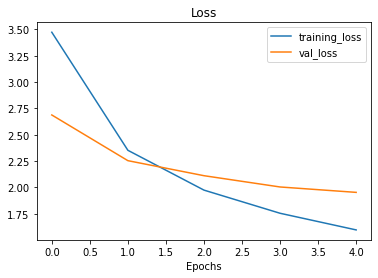

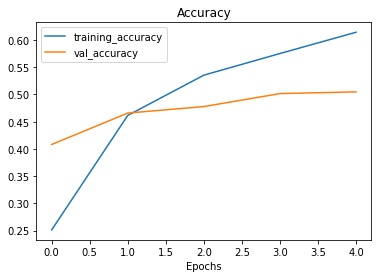

In [14]:
plot_loss_curves(history_all_classes_10_percent)

## Fine Tuning

In [15]:
# unfreezing all the layers in the base model

base_model.trainable = True

# refreeze every layer exvept for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [16]:
# Recompile the model

model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics = ["accuracy"])



In [17]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [18]:
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model_1.fit(train_data_all_10_percent,
            epochs = fine_tune_epochs,
            validation_data = test_data,
            validation_steps = int(0.15* len(test_data)),
            initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 86s 324ms/step - loss: 1.3552 - accuracy: 0.6442 - val_loss: 1.9504 - val_accuracy: 0.4979
Epoch 6/10
237/237 [==============================] - 74s 309ms/step - loss: 1.2261 - accuracy: 0.6808 - val_loss: 1.9068 - val_accuracy: 0.5101
Epoch 7/10
237/237 [==============================] - 71s 298ms/step - loss: 1.1421 - accuracy: 0.6937 - val_loss: 1.9018 - val_accuracy: 0.5172
Epoch 8/10
237/237 [==============================] - 69s 288ms/step - loss: 1.0781 - accuracy: 0.7067 - val_loss: 1.8763 - val_accuracy: 0.5185
Epoch 9/10
237/237 [==============================] - 64s 268ms/step - loss: 1.0209 - accuracy: 0.7269 - val_loss: 1.8936 - val_accuracy: 0.5177
Epoch 10/10
237/237 [==============================] - 68s 284ms/step - loss: 0.9571 - accuracy: 0.7418 - val_loss: 1.8940 - val_accuracy: 0.5188


In [19]:
feature_extraction_history = model_1.evaluate(test_data)

790/790 [==============================] - 104s 132ms/step - loss: 1.6343 - accuracy: 0.5703


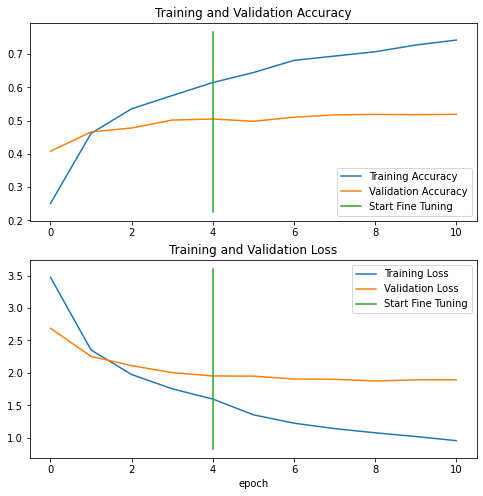

In [20]:
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

## Evaluating the performance of the big dog model across all different classes



In [21]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-04-12 07:01:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 142.250.152.128, 173.194.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  84.3MB/s    in 0.5s    

2022-04-12 07:01:57 (84.3 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [22]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

model_2 = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model/")

In [23]:
evaluate_loaded_model = model_2.evaluate(test_data)

790/790 [==============================] - 107s 133ms/step - loss: 1.8027 - accuracy: 0.6078


## making predictions with our trained model


In [24]:
pred_probs = model_2.predict(test_data, verbose=1)


790/790 [==============================] - 100s 124ms/step


In [25]:
# how many predictions are there?
len(pred_probs)

25250

In [26]:
# whats the shape of our predictions?
pred_probs.shape

(25250, 101)

In [27]:
# lets explore what the first 10 predictions look like
pred_probs[:10]

array([[5.9541941e-02, 3.5742332e-06, 4.1376889e-02, ..., 1.4138899e-09,
        8.3530460e-05, 3.0897565e-03],
       [9.6401680e-01, 1.3753089e-09, 8.4779976e-04, ..., 5.4286684e-05,
        7.8363253e-12, 9.8467334e-10],
       [9.5925868e-01, 3.2534019e-05, 1.4867033e-03, ..., 7.1891884e-07,
        5.4398350e-07, 4.0276311e-05],
       ...,
       [4.7313324e-01, 1.2931301e-07, 1.4805583e-03, ..., 5.9749611e-04,
        6.6969820e-05, 2.3469329e-05],
       [4.4571780e-02, 4.7265351e-07, 1.2258515e-01, ..., 6.3498578e-06,
        7.5319103e-06, 3.6778715e-03],
       [7.2438985e-01, 1.9249777e-09, 5.2310857e-05, ..., 1.2291447e-03,
        1.5793171e-09, 9.6395503e-05]], dtype=float32)

In [28]:
# what does the first prediction probs look like
pred_probs[0], len(pred_probs[0]), sum(pred_probs[0])

(array([5.9541941e-02, 3.5742332e-06, 4.1376889e-02, 1.0660903e-09,
        8.1613996e-09, 8.6639682e-09, 8.0926134e-07, 8.5652442e-07,
        1.9858850e-05, 8.0977554e-07, 3.1727692e-09, 9.8673388e-07,
        2.8532100e-04, 7.8049661e-10, 7.4230990e-04, 3.8915794e-05,
        6.4740016e-06, 2.4977169e-06, 3.7891397e-05, 2.0678806e-07,
        1.5538471e-05, 8.1506892e-07, 2.6230925e-06, 2.0010653e-07,
        8.3827712e-07, 5.4215743e-06, 3.7391112e-06, 1.3150788e-08,
        2.7761345e-03, 2.8051816e-05, 6.8561651e-10, 2.5574524e-05,
        1.6688934e-04, 7.6409645e-10, 4.0452869e-04, 1.3150487e-08,
        1.7957433e-06, 1.4448400e-06, 2.3062853e-02, 8.2465459e-07,
        8.5366531e-07, 1.7138503e-06, 7.0526130e-06, 1.8402382e-08,
        2.8553984e-07, 7.9482870e-06, 2.0682012e-06, 1.8525193e-07,
        3.3619781e-08, 3.1522335e-04, 1.0410886e-05, 8.5448306e-07,
        8.4741890e-01, 1.0555387e-05, 4.4094719e-07, 3.7404192e-05,
        3.5306137e-05, 3.2489079e-05, 6.7313988e

In [29]:
# we get one prediction probability per class
print(f"number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"what prediction probability sample 0 looks like :\n{pred_probs[0]}")
print(f"the class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

number of prediction probabilities for sample 0: 101
what prediction probability sample 0 looks like :
[5.9541941e-02 3.5742332e-06 4.1376889e-02 1.0660903e-09 8.1613996e-09
 8.6639682e-09 8.0926134e-07 8.5652442e-07 1.9858850e-05 8.0977554e-07
 3.1727692e-09 9.8673388e-07 2.8532100e-04 7.8049661e-10 7.4230990e-04
 3.8915794e-05 6.4740016e-06 2.4977169e-06 3.7891397e-05 2.0678806e-07
 1.5538471e-05 8.1506892e-07 2.6230925e-06 2.0010653e-07 8.3827712e-07
 5.4215743e-06 3.7391112e-06 1.3150788e-08 2.7761345e-03 2.8051816e-05
 6.8561651e-10 2.5574524e-05 1.6688934e-04 7.6409645e-10 4.0452869e-04
 1.3150487e-08 1.7957433e-06 1.4448400e-06 2.3062853e-02 8.2465459e-07
 8.5366531e-07 1.7138503e-06 7.0526130e-06 1.8402382e-08 2.8553984e-07
 7.9482870e-06 2.0682012e-06 1.8525193e-07 3.3619781e-08 3.1522335e-04
 1.0410886e-05 8.5448306e-07 8.4741890e-01 1.0555387e-05 4.4094719e-07
 3.7404192e-05 3.5306137e-05 3.2489079e-05 6.7313988e-05 1.2852399e-08
 2.6220215e-10 1.0318094e-05 8.5742751e-05 1.

In [30]:
test_data.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [31]:
test_data.class_names[52]

'gyoza'

In [32]:
# get the pred classes of each label
pred_classes = pred_probs.argmax(axis = 1)

#how do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [33]:
# how many pred_classes do we have
len(pred_classes)

25250

Now we've got a predictions array of all our model's predictions, to evaluate them, we need to compare them to the labels

In [34]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [35]:
# to get our test labels, we need to unravel our test_data BatchDataSet
y_labels=[]
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [36]:
# how many y_labels are there

len(y_labels)

25250

## Evaluating our model's predictions

 one way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score

In [37]:

from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)

In [38]:
sklearn_accuracy

0.6077623762376237

## Let's get visual making our confusion matrix


In [39]:
# get a list of class names
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [40]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
   
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         ytickslabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### changed(plot x-axis labels vertically) ###
  plt.xticks(rotation=90, fontsize = text_size)
  plt.yticks(fontsize = text_size)
  
  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  

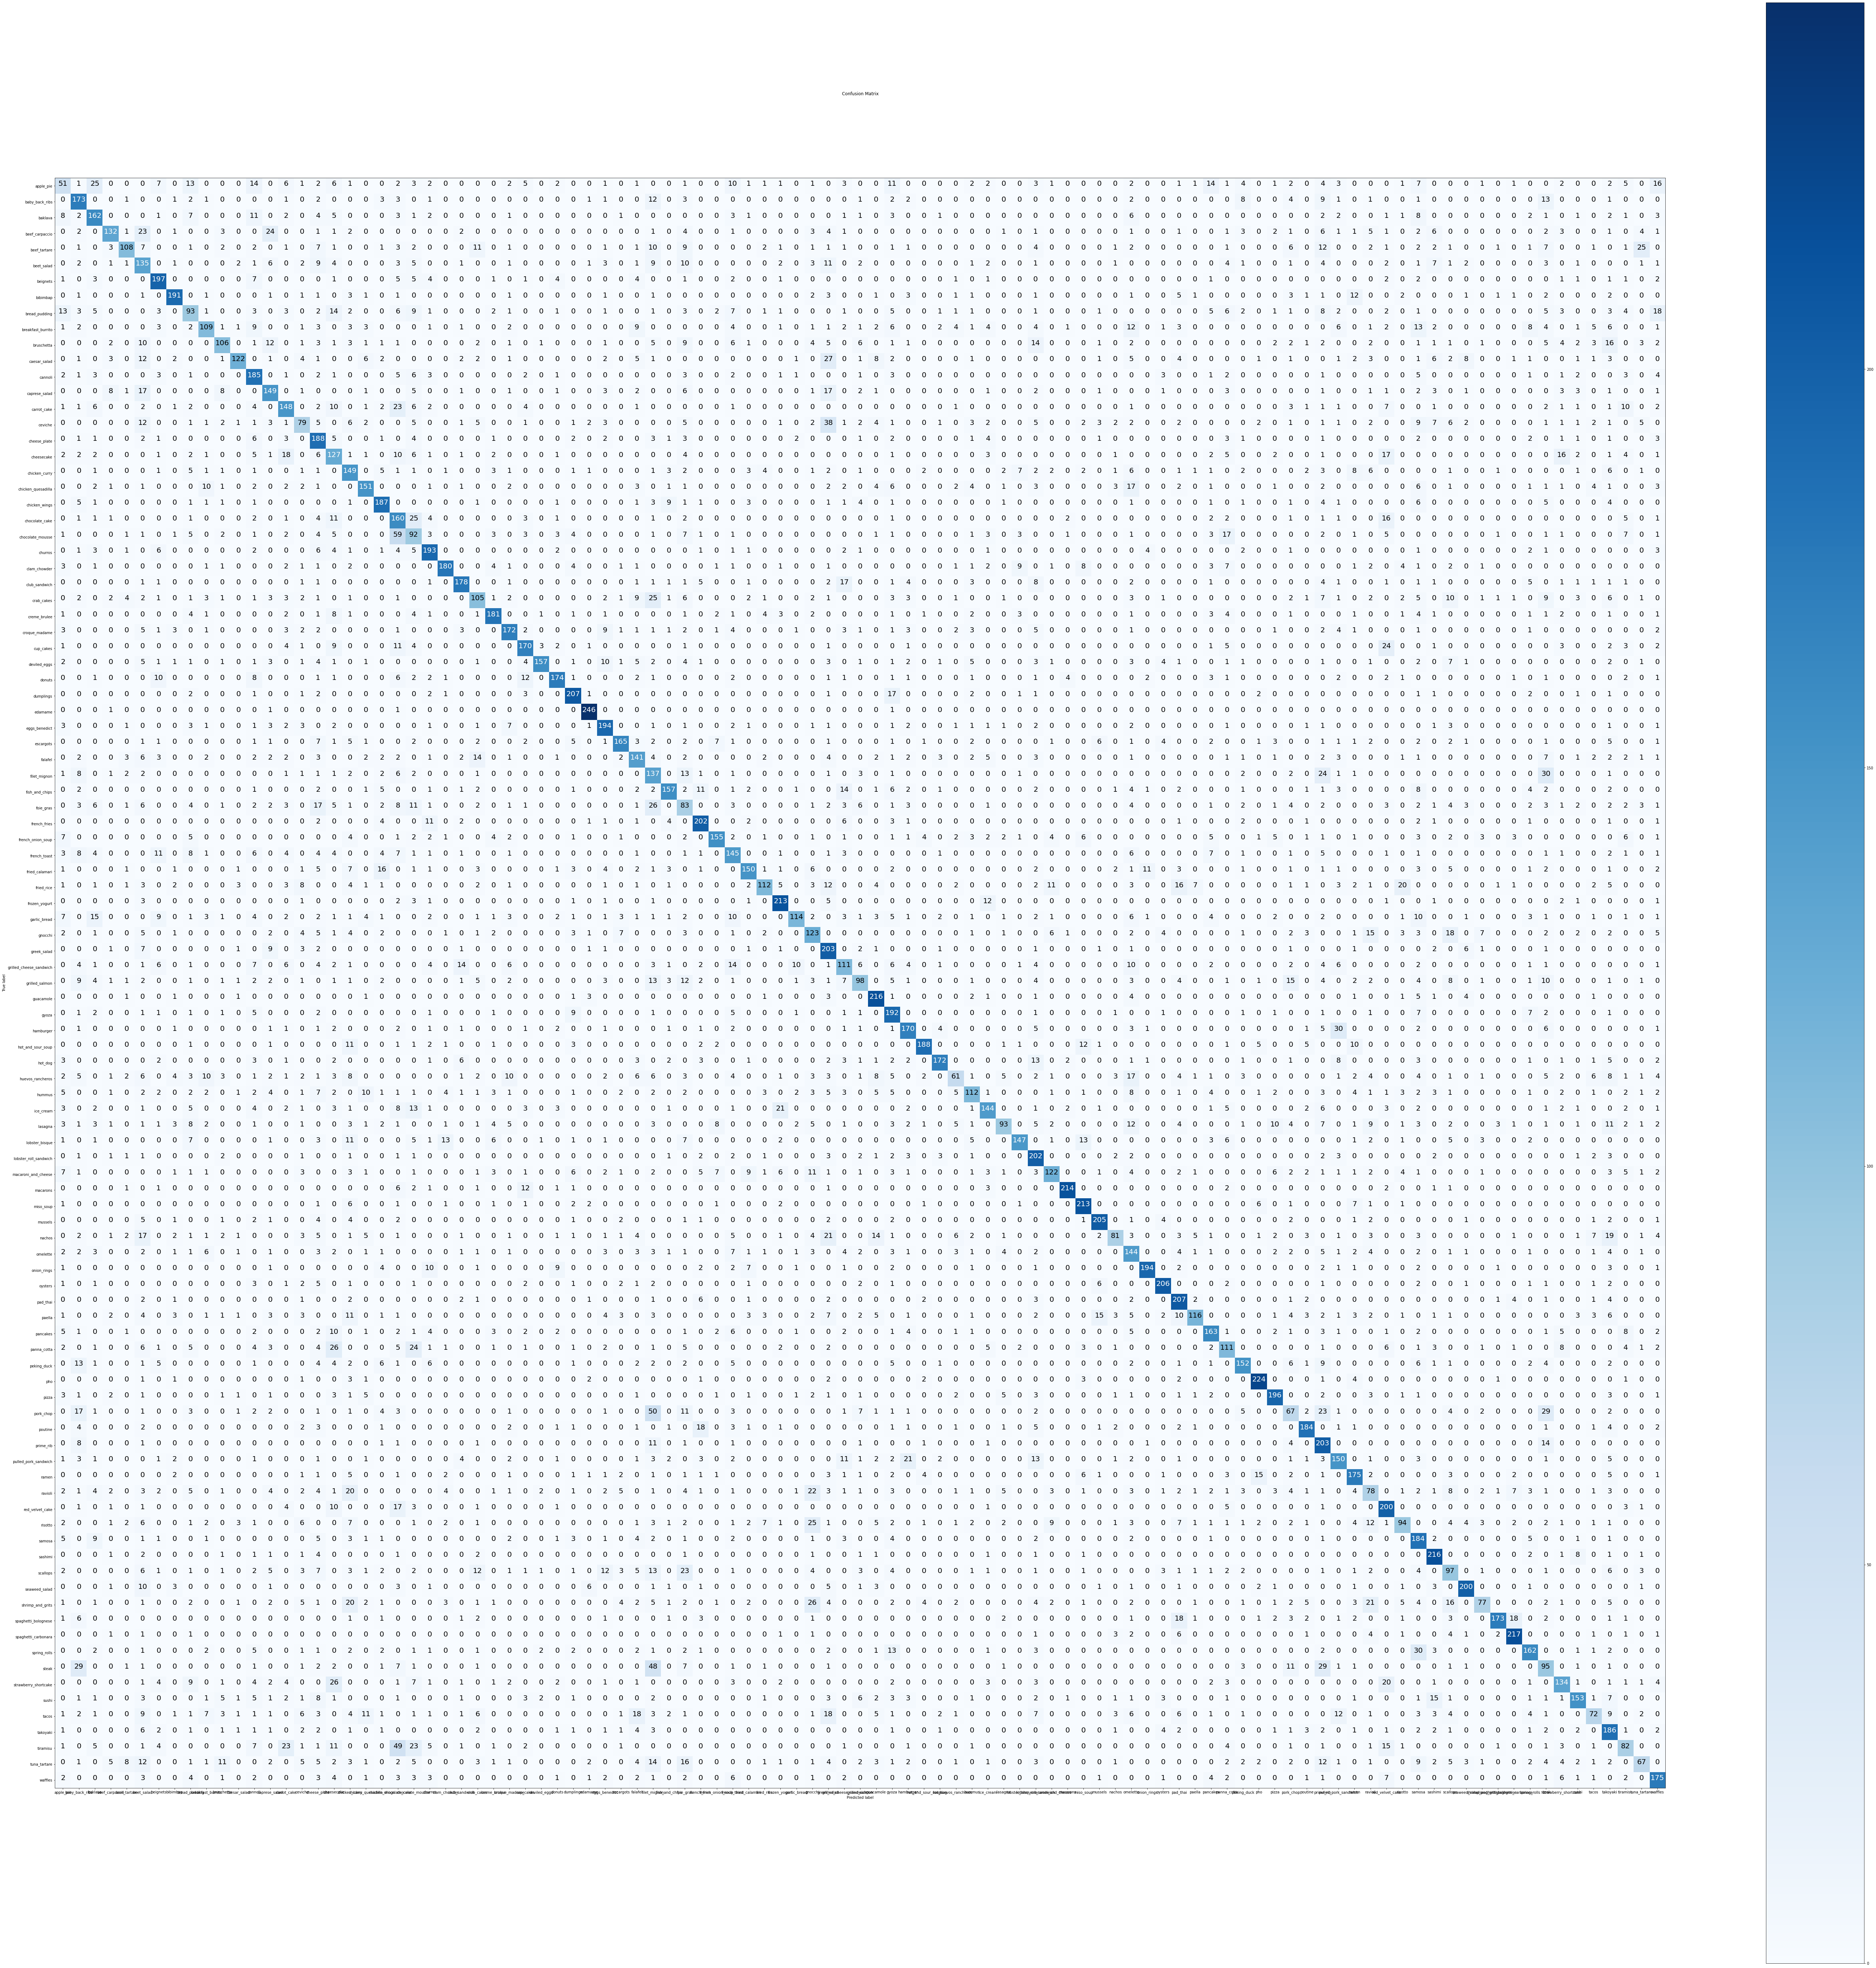

In [41]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_labels, pred_classes, classes = class_names, figsize= (100,100), text_size=(20), savefig = True)

## Let's keep the evaluation Train going, time for a classification report

Scikit-Learn has a helpful function for acquiring many different classification metrics per class call Classification Report


In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_labels, 
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [43]:
# get a dictionary of the classification report

classification_report_dict  = classification_report(y_labels, pred_classes, output_dict = True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [44]:
class_names[70]

'pad_thai'

In [45]:
classification_report_dict["99"] ["f1-score"]

0.35356200527704484

In [46]:
# lets plot all of our classes F1-scores
class_f1_scores = {}

# loop through classification report dictionary items
for k,v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    # add classnames and f1 scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [47]:
# Turn F1-scores into dataframe for visualisation

import pandas as pd

f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1_scores": list(class_f1_scores.values())}).sort_values("f1_scores", ascending= False)


In [48]:
f1_scores

,class_names,f1_scores
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


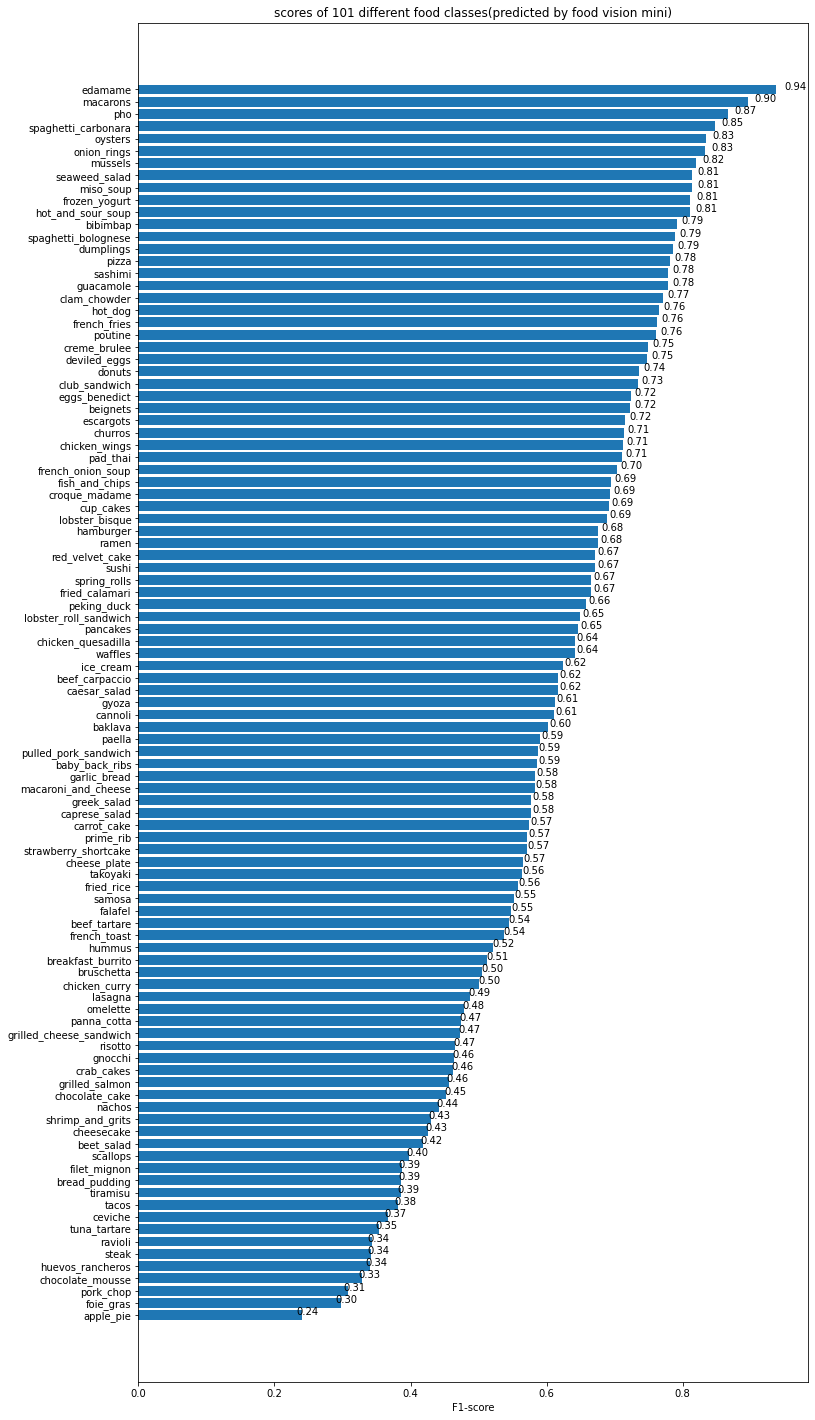

In [49]:
# plot the horizontal bar chart of the f1_scores

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1_scores"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("scores of 101 different food classes(predicted by food vision mini)")
ax.invert_yaxis();0

def autolabel(rects):
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## visualising predictions on costum images


# we need a function to load and preprocess images, specifically it will need to:
* Read in a target image filepath using tf.io.read_file() 
* Turn the iimage into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 and 1

In [51]:
# create a function to load and prepare images
def load_and_prep_image(filename , img_shape = 224, scale = True):
  """
  Reads in an image from file name, turns it into a tensor and reshape into specific shape
  (img_shape, img_shape, color_channel=3)
  """
  # read in the target image
  img = tf.io.read_file(filename)
  
  # decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  #resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  #scale?
  if scale:
    #rescale the image
    return img/255.
  else:
    return img

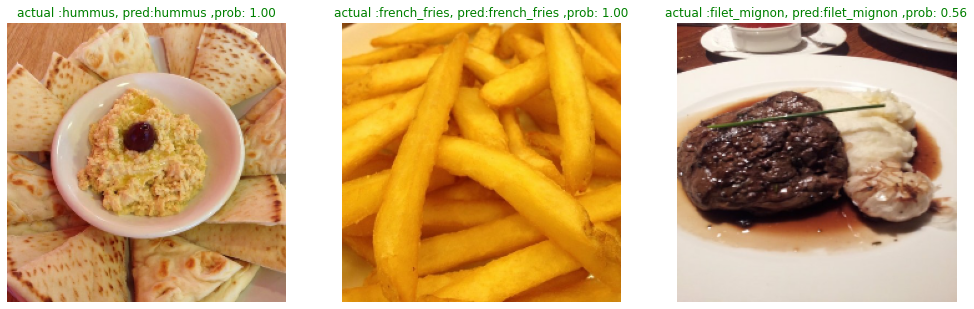

In [72]:
# make predictions on a series of random images
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
 

  # load the image and make predictions
  img = load_and_prep_image(filepath, scale = False)
  img_expanded = tf.expand_dims(img, axis = 0)
  pred_prob = model_2.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()]


  # plot the images
  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual :{class_name}, pred:{pred_class} ,prob: {pred_prob.max():.2f}", c= title_color)
  plt.axis(False);

### Finding the most wrong predictions

To find out where our model is most wrong, lets write some code to find out the following:

* Get all of the image filepaths in the test dataset using list_files() method
* Create a pandas dataframe of the image filepaths, ground truth labels, predicted classes, max prediction probabilities
* Using our Dataframe to find all the wrong predictions.
* sort the dataframe based on the wrong predictions.
* Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [79]:
# get all of the image filepaths in the test dataset

filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                      shuffle = False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [86]:
# 2. create a dataframe of different parameters 
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred" : pred_classes,
                        "pred_conf": pred_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,52,0.847419,apple_pie,gyoza
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.964017,apple_pie,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.959259,apple_pie,apple_pie
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,80,0.658607,apple_pie,pulled_pork_sandwich
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,79,0.367902,apple_pie,prime_rib
...,...,...,...,...,...,...
25245,b'101_food_classes_10_percent/test/waffles/942...,100,100,0.972823,waffles,waffles
25246,b'101_food_classes_10_percent/test/waffles/954...,100,16,0.878027,waffles,cheese_plate
25247,b'101_food_classes_10_percent/test/waffles/961...,100,100,0.537900,waffles,waffles
25248,b'101_food_classes_10_percent/test/waffles/970...,100,94,0.501951,waffles,strawberry_shortcake


In [89]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,52,0.847419,apple_pie,gyoza,False
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.964017,apple_pie,apple_pie,True
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.959259,apple_pie,apple_pie,True
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,80,0.658607,apple_pie,pulled_pork_sandwich,False
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,79,0.367902,apple_pie,prime_rib,False


In [90]:
#4. Sort our DataFrame to have most wrong predictionss at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending = False)
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
21810,b'101_food_classes_10_percent/test/scallops/17...,87,29,0.999997,scallops,cup_cakes,False
231,b'101_food_classes_10_percent/test/apple_pie/8...,0,100,0.999995,apple_pie,waffles,False
15359,b'101_food_classes_10_percent/test/lobster_rol...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,b'101_food_classes_10_percent/test/strawberry_...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,b'101_food_classes_10_percent/test/samosa/3140...,85,92,0.999981,samosa,spring_rolls,False
24540,b'101_food_classes_10_percent/test/tiramisu/16...,98,83,0.999947,tiramisu,red_velvet_cake,False
2511,b'101_food_classes_10_percent/test/bruschetta/...,10,61,0.999945,bruschetta,lobster_roll_sandwich,False
5574,b'101_food_classes_10_percent/test/chocolate_m...,22,21,0.999939,chocolate_mousse,chocolate_cake,False
17855,b'101_food_classes_10_percent/test/paella/2314...,71,65,0.999931,paella,mussels,False
23797,b'101_food_classes_10_percent/test/sushi/16593...,95,86,0.999904,sushi,sashimi,False


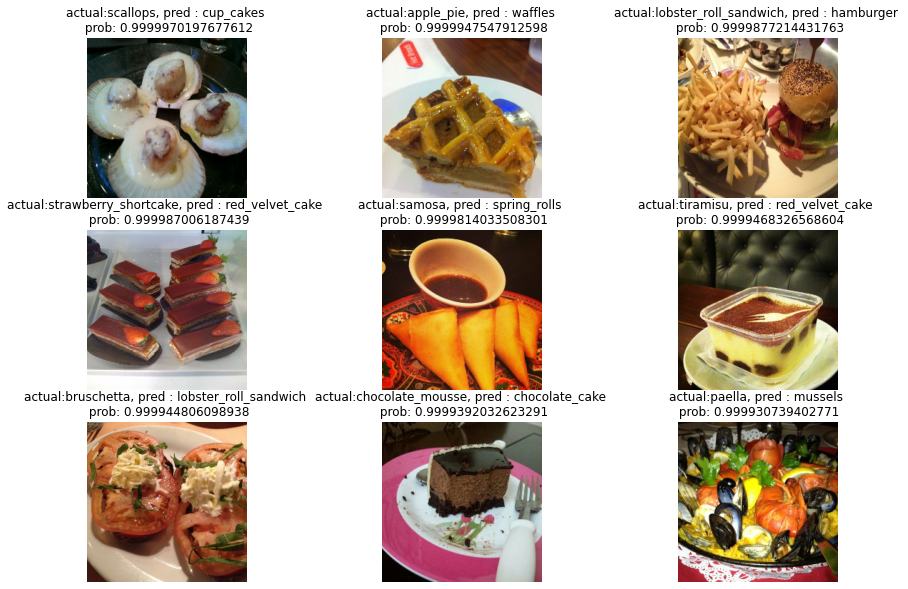

In [96]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability

images_to_view = 9
start_index = 0
plt.figure(figsize = (15,10))
for i , row in enumerate(top_100_wrong[start_index:start_index+ images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img = load_and_prep_image(row[1], scale = False)
  _, _, _, _, pred_prob , y_true_classname, y_pred_classname, _ = row # only interested in few parameters in the them
  plt.imshow(img/255.)
  plt.title(f"actual:{y_true_classname}, pred : {y_pred_classname} \n prob: {pred_prob}")
  plt.axis(False)

## Test our Big Dog Model on our own costum images

In [101]:
# get costum images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2022-04-12 09:38:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 74.125.132.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  29.2MB/s    in 0.4s    

2022-04-12 09:38:57 (29.2 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]



In [102]:
# Get the costum food images filepaths

custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg']

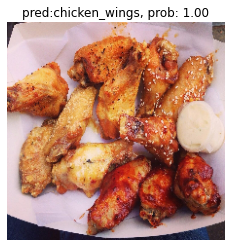

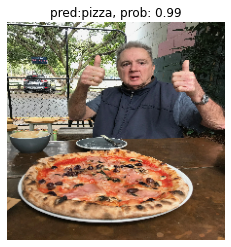

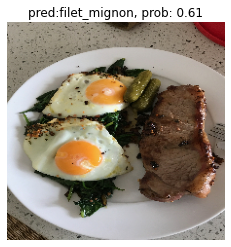

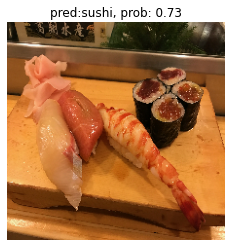

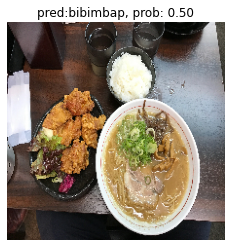

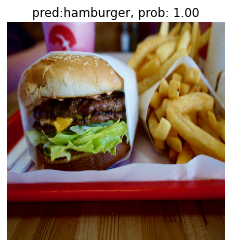

In [106]:
# make and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model_2.predict(tf.expand_dims(img, axis = 0))
  pred_class = class_names[pred_prob.argmax()]
  # plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred:{pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)